In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [9]:
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "pose_iter_160000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

In [9]:
def getLengthLimb(data, keypoint1: int, keypoint2: int):
    if type(data[keypoint1, 0]) != type(None) and type(data[keypoint2, 0]) != type(None):
        return np.linalg.norm([data[keypoint1, 0:2] - data[keypoint2, 0:2]])
    return 0

def preprocess_keypoints(keypoints:np.ndarray):
    if type(keypoints) != type(None):
        assert keypoints.shape == (15,2)
        # Find bounding box
        min_x, max_x = float("inf"), 0.0
        min_y, max_y = float("inf"), 0.0
        for k in keypoints:
            if type(k[0]) != type(None):  # If keypoint exists
                min_x = min(min_x, k[0])
                max_x = max(max_x, k[0])
                min_y = min(min_y, k[1])
                max_y = max(max_y, k[1])
                

        # Centering
        np.subtract(
            keypoints[:, 0],
            (min_x + max_x) / 2.,
            where=keypoints[:, 0] != None,
            out=keypoints[:, 0],
        )
        np.subtract(
            (min_y + max_y) / 2.,
            keypoints[:, 1],
            where=keypoints[:, 0] != None,
            out=keypoints[:, 1],
        )

        # Scaling  
        normalizedPartsLength = np.array(
            [
                getLengthLimb(keypoints, 2,  8) * (16.0 / 5.2),  # Torso right
                getLengthLimb(keypoints, 5, 11) * (16.0 / 5.2),  # Torso left
                getLengthLimb(keypoints, 0, 1) * (16.0 / 2.5),  # Neck
                getLengthLimb(keypoints, 8, 9) * (16.0 / 3.6),  # Right thigh
                getLengthLimb(keypoints, 9, 10) * (16.0 / 3.5),  # Right lower leg
                getLengthLimb(keypoints, 11, 12) * (16.0 / 3.6),  # Left thigh
                getLengthLimb(keypoints, 12, 13) * (16.0 / 3.5),  # Left lower leg
            ]
        )
        
        print(normalizedPartsLength)
        # Mean of non-zero lengths
        normalizedPartsLength = normalizedPartsLength[normalizedPartsLength > 0.0]
        if len(normalizedPartsLength)>0:
            scaleFactor = np.mean(normalizedPartsLength)
        else:
            return None
        
        print(scaleFactor)

        # Populate None keypoints with 0s
        keypoints[keypoints == None] = 0.0

        # Normalize
        np.divide(keypoints, scaleFactor, out=keypoints[:, 0:2])

        if np.any((keypoints > 1.0) | (keypoints < -1.0)):
            #print("Scaling error")
            return None

        return keypoints.astype('float32')
    else: return None

In [10]:
posePartPairs={
    "Torso":[0, 1], 
    "Shoulder (right)":[1, 2],
    "Shoulder (left)":[1, 5],
    "Arm (right)":[2, 3],
    "Forearm (right)":[3, 4],
    "Arm (left)":[5, 6],
    "Forearm (left)":[6, 7],
    #"Hip (right)":[8, 9],
    "Thigh (right)":[8, 9],
    "Leg (right)":[9, 10],
   # "Hip (left)":[8, 12],
    "Thigh (left)":[11, 12],
    "Leg (left)":[12, 13]
}
color_map = plt.cm.get_cmap("nipy_spectral", len(posePartPairs))

[272.75495646 349.53900325 436.18711581 398.34224382 402.28571429
 293.33333333 408.8810016 ]
365.9033383651303


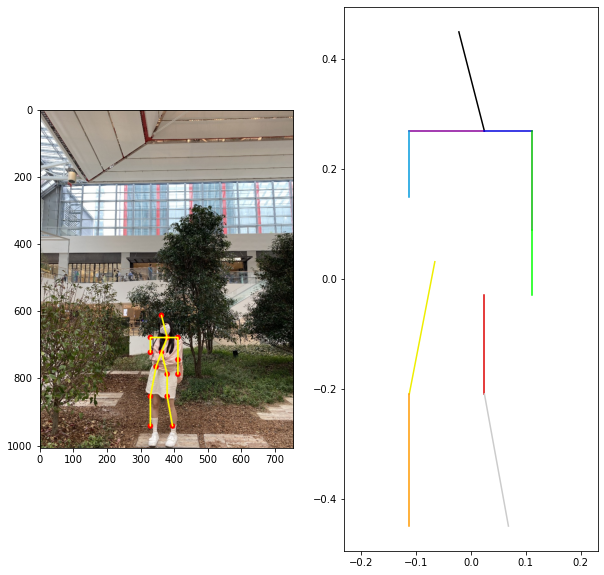

In [65]:
frame = cv2.imread("realpose3/_1.jpg")
#14번 17번 18번 실패
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (368, 368),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()


H = output.shape[2]
W = output.shape[3]

nPoints = 15

points = []
for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image     
    x = frameWidth * ((point[0]) / W)
    y = frameHeight * ((point[1]) / H)

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        
        points.append((int(x), int(y)))
    else :
        points.append(None)
        
        
        
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
points = np.array(points) * 1.0

keypoints = preprocess_keypoints(points)

plt.subplot(121)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.axis('equal')
sample2d = keypoints.reshape(-1,2)
for i,p in enumerate(posePartPairs.values()):
     plt.plot(*sample2d[p].T, c=color_map(i))

In [78]:
np.mean(points[:,0])

0.26666666666666666

In [58]:
answer = x_ / sig
print(points)
print(x_)
print(answer)

[(2037, 1051), (2037, 1577), (1774, 1665), (1380, 1753), (1051, 1665), (2366, 1665), (2498, 2191), (2695, 2629), (1906, 2541), (1774, 3243), (1774, 3418), (2169, 2541), (2235, 2980), (2235, 3418), (2037, 2103)]
[[ -109.93333333 -1095.93333333]
 [ -109.93333333  -569.93333333]
 [ -372.93333333  -481.93333333]
 [ -766.93333333  -393.93333333]
 [-1095.93333333  -481.93333333]
 [  219.06666667  -481.93333333]
 [  351.06666667    44.06666667]
 [  548.06666667   482.06666667]
 [ -240.93333333   394.06666667]
 [ -372.93333333  1096.06666667]
 [ -372.93333333  1271.06666667]
 [   22.06666667   394.06666667]
 [   88.06666667   833.06666667]
 [   88.06666667  1271.06666667]
 [ -109.93333333   -43.93333333]]
[[-0.18288648 -1.82320849]
 [-0.18288648 -0.94814827]
 [-0.62041659 -0.80175036]
 [-1.27587995 -0.65535245]
 [-1.82320849 -0.80175036]
 [ 0.36444207 -0.80175036]
 [ 0.58403893  0.07330986]
 [ 0.91177061  0.80197218]
 [-0.40081973  0.65557427]
 [-0.62041659  1.82343031]
 [-0.62041659  2.114562

In [50]:
x = np.array([10,20,34,90,56.0])
mu = np.mean(x) 
x_ = x - mu
print(x)
print(x_)
print(np.mean(x_))

[10. 20. 34. 90. 56.]
[-32. -22.  -8.  48.  14.]
0.0


In [55]:
x = np.array([110,120,134,190,156.0])
mu = np.mean(x) 
sig = np.std(x)
x_ = x - mu
answer = x_ / sig
print(x)
print(x_)
print(np.mean(x_))
print(sig)
print(answer)

an_mu = np.mean(answer)
an_sig = np.std(answer)

print(an_mu)
print(an_sig)

[110. 120. 134. 190. 156.]
[-32. -22.  -8.  48.  14.]
0.0
28.53769437077915
[-1.12132394 -0.77091021 -0.28033099  1.68198592  0.49057923]
2.2204460492503132e-17
1.0


In [36]:
def getLengthLimb(data, keypoint1: int, keypoint2: int):
    if type(data[keypoint1, 0]) != type(None) and type(data[keypoint2, 0]) != type(None):
        return np.linalg.norm([data[keypoint1, 0:2] - data[keypoint2, 0:2]])
    return 0

def preprocess_keypoints(keypoints:np.ndarray):
    if type(keypoints) != type(None):
        assert keypoints.shape == (15,2)
        # Find bounding box
        min_x, max_x = float("inf"), 0.0
        min_y, max_y = float("inf"), 0.0
        for k in keypoints:
            if type(k[0]) != type(None):  # If keypoint exists
                min_x = min(min_x, k[0])
                max_x = max(max_x, k[0])
                min_y = min(min_y, k[1])
                max_y = max(max_y, k[1])
                

        # Centering
        np.subtract(
            keypoints[:, 0],
            (min_x + max_x) / 2.,
            where=keypoints[:, 0] != None,
            out=keypoints[:, 0],
        )
        np.subtract(
            (min_y + max_y) / 2.,
            keypoints[:, 1],
            where=keypoints[:, 0] != None,
            out=keypoints[:, 1],
        )

        # Scaling  
        normalizedPartsLength = np.array(
            [
                getLengthLimb(keypoints, 2,  8) * (16.0 / 5.2),  # Torso right
                getLengthLimb(keypoints, 5, 11) * (16.0 / 5.2),  # Torso left
                getLengthLimb(keypoints, 0, 1) * (16.0 / 2.5),  # Neck
                getLengthLimb(keypoints, 8, 9) * (16.0 / 3.6),  # Right thigh
                getLengthLimb(keypoints, 9, 10) * (16.0 / 3.5),  # Right lower leg
                getLengthLimb(keypoints, 11, 12) * (16.0 / 3.6),  # Left thigh
                getLengthLimb(keypoints, 12, 13) * (16.0 / 3.5),  # Left lower leg
            ]
        )
        
        print(normalizedPartsLength)
        # Mean of non-zero lengths
        normalizedPartsLength = normalizedPartsLength[normalizedPartsLength > 0.0]
        if len(normalizedPartsLength)>0:
            scaleFactor = np.mean(normalizedPartsLength)
        else:
            return None
        
        print(scaleFactor)

        # Populate None keypoints with 0s
        keypoints[keypoints == None] = 0.0

        # Normalize
        np.divide(keypoints, scaleFactor, out=keypoints[:, 0:2])

        if np.any((keypoints > 1.0) | (keypoints < -1.0)):
            #print("Scaling error")
            return None

        return keypoints.astype('float32')
    else: return None

In [122]:
keypoints = preprocess_keypoints(points)
keypoints

[2725.81348804 2762.70170486 3366.4        3174.67758643  800.
 1973.03801594 2002.28571429]
2400.702358508962


array([[ 0.06831334,  0.49298072],
       [ 0.06831334,  0.2738782 ],
       [-0.04123793,  0.23722224],
       [-0.20535657,  0.2005663 ],
       [-0.3423998 ,  0.23722224],
       [ 0.20535657,  0.23722224],
       [ 0.26034048,  0.0181197 ],
       [ 0.3423998 , -0.1643269 ],
       [ 0.01374598, -0.12767097],
       [-0.04123793, -0.4200854 ],
       [-0.04123793, -0.49298072],
       [ 0.12329725, -0.12767097],
       [ 0.1507892 , -0.31053412],
       [ 0.1507892 , -0.49298072],
       [ 0.06831334,  0.05477564]], dtype=float32)

In [106]:
posePartPairs={
    "Torso":[0, 1], 
    "Shoulder (right)":[1, 2],
    "Shoulder (left)":[1, 5],
    "Arm (right)":[2, 3],
    "Forearm (right)":[3, 4],
    "Arm (left)":[5, 6],
    "Forearm (left)":[6, 7],
    #"Hip (right)":[8, 9],
    "Thigh (right)":[8, 9],
    "Leg (right)":[9, 10],
   # "Hip (left)":[8, 12],
    "Thigh (left)":[11, 12],
    "Leg (left)":[12, 13],
   # "Neck":[1, 0],
   ##" "Eye (right)":[0, 15],
   ##" "Ear (right)":[15, 17],
   ##" "Eye (left)":[0, 16],
  ##"  "Ear (left)":[16, 18],
  ##"  ##"Foot (left)":[14, 19],
    ##""Toe (left)":[19, 20],
   ##" "Heel (left)":[14, 21],
    ##""Foot (right)":[11, 22],
   ##" "Toe (right)":[22, 23],
   ##" "Heel (right)":[11, 24],
}
color_map = plt.cm.get_cmap("nipy_spectral", len(posePartPairs))

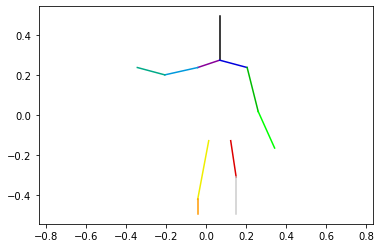

In [123]:
plt.axis('equal')
sample2d = keypoints.reshape(-1,2)
for i,p in enumerate(posePartPairs.values()):
     plt.plot(*sample2d[p].T, c=color_map(i))

In [45]:
import os
dir_list = os.listdir("realpose3")
print(dir_list)

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '_1.jpg', '_2.jpg', '_3.jpg', '_4.jpg', '_6.jpg', '_7.jpg', '_8.jpg', '_9.jpg', '_10.jpg', '_11.jpg', '_12.jpg', '_13.jpg', '_14.jpg', '_15.jpg', '_16.jpg', '_17.jpg', '_18.jpg', '__1.jpg', '__2.jpg', '__3.jpg', '__4.jpg', '__6.jpg', '__7.jpg', '__8.jpg', '__9.jpg', '__10.jpg', '__11.jpg', '__12.jpg', '__13.jpg', '__14.jpg', '__15.jpg', '__16.jpg', '__17.jpg', '__18.jpg']


In [ ]:
i = 1
for file in dir_list :
    b_n = os.path.join("realpose3", file)
    a_n = str(i) + ".jpg"
    a_n = os.path.join("realpose3", a_n)
    os.rename(b_n, a_n)
    i += 1 #폴더 속 파일명 일괄 변경

In [44]:
for file in dir_list :
    frame = cv2.imread("realpose3/" + file)  
    frame = cv2.resize(frame,  dsize=(0, 0), fx=0.25, fy=0.25)    
    #output = drawpose(frame)
    cv2.imwrite("realpose3/_" + file, frame)

In [ ]:
frame = cv2.imread("realpose/7.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (368, 368),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()


H = output.shape[2]
W = output.shape[3]

nPoints = 15

points = []
for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image     
    x = frameWidth * ((point[0]) / W)
    y = frameHeight * ((point[1]) / H)

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        
        points.append((int(x), int(y)))
    else :
        points.append(None)
        
        
        
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
points = np.array(points) * 1.0

keypoints = preprocess_keypoints(points)

plt.subplot(121)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.axis('equal')
sample2d = keypoints.reshape(-1,2)
for i,p in enumerate(posePartPairs.values()):
     plt.plot(*sample2d[p].T, c=color_map(i))

In [45]:
def getPose(net, image) :    
    frame = np.copy(image)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (368, 368),
                          (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    
    
    return output


def drawPose(image, output) :
    
    threshold = 0.1
    
    frameWidth = image.shape[1]
    frameHeight = image.shape[0]

    
    frame = image.copy()
    H = output.shape[2]
    W = output.shape[3]

    nPoints = 15

    points = []
    for i in range(nPoints):
    # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image     
        x = frameWidth * ((point[0]) / W)
        y = frameHeight * ((point[1]) / H)

        if prob > threshold : 
            cv2.circle(frame, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            #cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)


            points.append((int(x), int(y)))
        else :
            points.append(None)
        
        
        
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
            
    return frame      



def getNormalizedPose(image, output) :
    threshold = 0.1
    
    frameWidth = image.shape[1]
    frameHeight = image.shape[0]
    
    
    H = output.shape[2]
    W = output.shape[3]

    nPoints = 15

    points = []
    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image     
        x = frameWidth * ((point[0]) / W)
        y = frameHeight * ((point[1]) / H)

        if prob > threshold : 
            points.append((int(x), int(y)))
        else :
            points.append(None)
    points = np.array(points) * 1.0
    keypoints = preprocess_keypoints(points)
    return keypoints

In [1]:
imaeg = 
pose = getPose(image)




drawSkeleton(pose)
rawPose(image, pose)    





    

NameError: name 'getPose' is not defined

In [26]:
dir = "realpose3"
dir_list = os.listdir(dir)
for file in dir_list :    
    print(file)       
    image =  cv2.imread(dir + "/" + file)
    image = cv2.resize(image,  dsize=(0, 0), fx=0.25, fy=0.25)    
    
    #pose = getPose(image)    
    #ret = drawPose(image, pose)   
    #cv2.imwrite(dir + "/_" + file) 

1.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
2.jpg
3.jpg
6.jpg
7.jpg
8.jpg
9.jpg


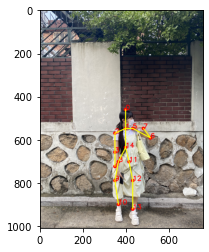

In [27]:
pose = getPose(net, image)  


out = drawPose(image, pose)

plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))


1.jpg
[339.43914758 349.53900325 436.18711581 302.90771931 402.28571429
 293.33333333 408.8810016 ]
361.7961478822943
[[-0.0221119   0.45467594]
 [ 0.02487589  0.27225277]
 [-0.11332349  0.27225277]
 [-0.11332349  0.15063731]
 [-0.11332349  0.15063731]
 [ 0.11332349  0.27225277]
 [ 0.11332349  0.08982959]
 [ 0.11332349 -0.02902187]
 [-0.0663357  -0.02902187]
 [-0.11332349 -0.21144503]
 [-0.11332349 -0.45467594]
 [ 0.02487589 -0.02902187]
 [ 0.02487589 -0.21144503]
 [ 0.06909969 -0.45467594]
 [-0.0221119   0.15063731]]
10.jpg
[276.92307692 296.02494697 390.4        347.37818719 347.21798129
 333.33333333 346.52514118]
333.97180955612555
[[ 0.0509025   0.4730938 ]
 [ 0.0509025   0.2904437 ]
 [-0.0509025   0.24552971]
 [-0.0509025   0.15570177]
 [-0.11677632  0.02095985]
 [ 0.1527075   0.24552971]
 [ 0.11977059  0.06587382]
 [ 0.11977059 -0.06886809]
 [-0.0509025  -0.02395412]
 [-0.11677632 -0.24852397]
 [-0.1527075  -0.4730938 ]
 [ 0.0509025  -0.02395412]
 [ 0.0509025  -0.24852397]
 [ 0.

C:\Users\user\AppData\Local\Temp/ipykernel_4936/2822143409.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points = np.array(points) * 1.0


TypeError: can't multiply sequence by non-int of type 'float'

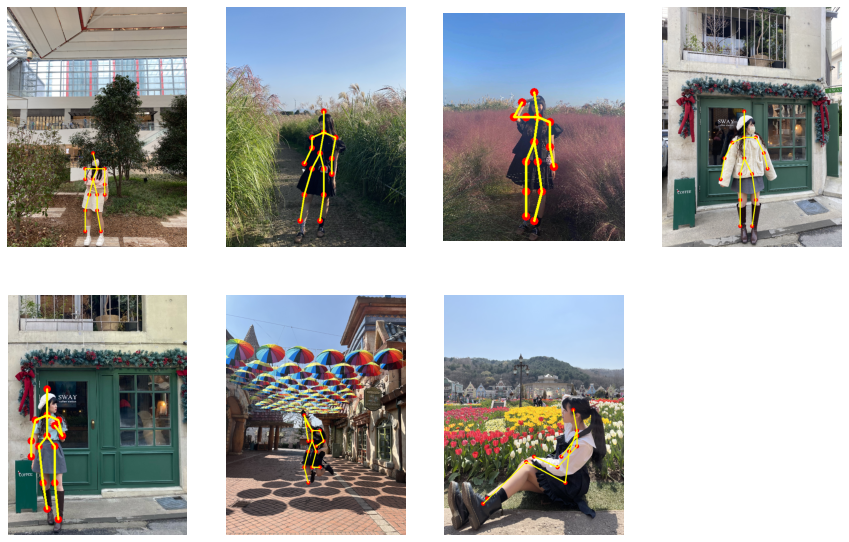

In [47]:
dir = "select"
dir_list = os.listdir(dir)
i = 1
plt.figure(figsize=[15,15])
for file in dir_list :    
    print(file)       
    image =  cv2.imread(dir + "/" + file)
    image = cv2.resize(image,  dsize=(0, 0), fx=0.25, fy=0.25)      
    pose = getPose(net, image)  
    out = drawPose(image, pose)
    plt.subplot(3,4,i)   
    plt.axis("off") 
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))    
    i = i + 1
    print(getNormalizedPose(image, pose))

In [46]:
getNormalizedPose(image, pose)

[409.12664957 476.72452443 556.8        393.15124473 508.14878104
 393.97938155 603.42857143]
477.3370218204773


array([[-0.06913354,  0.48183987],
       [-0.06913354,  0.2995787 ],
       [-0.17178638,  0.25348967],
       [-0.17178638,  0.06913354],
       [-0.17178638, -0.06913354],
       [ 0.        ,  0.2995787 ],
       [ 0.17178638,  0.20740063],
       [ 0.10265284,  0.2995787 ],
       [-0.13826708, -0.02304452],
       [-0.17178638, -0.20530568],
       [-0.13826708, -0.4357508 ],
       [-0.03561425, -0.02304452],
       [ 0.        , -0.20530568],
       [ 0.        , -0.48183987],
       [-0.06913354,  0.11522257]], dtype=float32)